# PACE MOANA Data Visualization: Time Series & Hovmoller Diagrams
**Author:** Shailja Gangrade (Brown University). Adapted from Carina Poulin (NASA, SSAI). Prepared for the PACE Hackweek 2025.

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

<div class="alert alert-warning" role="alert">

You need up to 4GB of memory to run this notebook

</div>

[edl]: https://urs.earthdata.nasa.gov/

## Summary

[Add here]

## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

Set (and persist to your user profile on the host, if needed) your Earthdata Login credentials.

In [89]:
auth = earthaccess.login()

[back to top](#Contents)

## 2. Plot a timeline of the plankton types for a region of interest

We are going to use what we just learned to create a timeline for a chosen area. First, we will get data for the entire PACE mission to date.

### Get data

In [90]:
tspan = ("2024-04-01", "2025-05-31")

In [91]:
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

results_cphyto = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CARBON",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

results_poc = earthaccess.search_data(
    short_name="PACE_OCI_L3M_POC",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

results_chl = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

Since we want to draw a timeline, we will get the date information from the dataset's attribute with the new function we are creating: `time_from_attr`.

In [8]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds

In [92]:
path_files = earthaccess.open(results_moana)
paths_cphyto = earthaccess.open(results_cphyto)
paths_poc = earthaccess.open(results_poc)
paths_chl = earthaccess.open(results_chl)

QUEUEING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/376 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

We use `time_from_attr` in the `preprocess` parameter of `xr.open_mfdataset`. We then can see the date coordinate added to the dataset.

In [10]:
dataset_moana = xr.open_mfdataset(
    path_files, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_moana

<xarray.Dataset> Size: 7GB
Dimensions:          (date: 376, lat: 1400, lon: 1100, rgb: 3,
                      eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (date, rgb, eightbitcolor) uint8 289kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

In [93]:
dataset_cphyto = xr.open_mfdataset(
    paths_cphyto, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_POC = xr.open_mfdataset(
    paths_poc, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_chl = xr.open_mfdataset(
    paths_chl, preprocess=time_from_attr, combine="nested", concat_dim="date"
)

NameError: name 'dataset' is not defined

In [94]:
dataset_bgc = xr.merge([dataset_cphyto,dataset_POC,dataset_chl])

### Clean up data

We then clean up our dataset using the built-in `valid_min` and `valid_max` values and remove the palette variable that we will not be using.

In [95]:
dataset_moana["prococcus_moana"] = dataset_moana["prococcus_moana"].clip(
    min=dataset_moana["prococcus_moana"].attrs["valid_min"],
    max=dataset_moana["prococcus_moana"].attrs["valid_max"],
)
dataset_moana["syncoccus_moana"] = dataset_moana["syncoccus_moana"].clip(
    min=dataset_moana["syncoccus_moana"].attrs["valid_min"],
    max=dataset_moana["syncoccus_moana"].attrs["valid_max"],
)
dataset_moana["picoeuk_moana"] = dataset_moana["picoeuk_moana"].clip(
    min=dataset_moana["picoeuk_moana"].attrs["valid_min"],
    max=dataset_moana["picoeuk_moana"].attrs["valid_max"],
)

dataset_bgc["carbon_phyto"] = dataset_bgc["carbon_phyto"].clip(
    min=dataset_bgc["carbon_phyto"].attrs["valid_min"],
    max=dataset_bgc["carbon_phyto"].attrs["valid_max"],
)
dataset_bgc["chlor_a"] = dataset_bgc["chlor_a"].clip(
    min=dataset_bgc["chlor_a"].attrs["valid_min"],
    max=dataset_bgc["chlor_a"].attrs["valid_max"],
)
# poc valid_min and valid_max are incorrect

In [96]:
dataset_phy = dataset_moana.drop_vars(["palette"])
dataset_bgc = dataset_bgc.drop_vars(["palette"])

Let's average, normalize and reorder our dataset as seen in the previous example.

In [13]:
## Optionally, normalize the PCC data:
dataset_phy_mean = dataset_phy.mean("date")

dataset_phy_mean = dataset_phy_mean.astype(np.float64)
dataset_norm = (
    (dataset_phy_mean - dataset_phy_mean.min())
    / (dataset_phy_mean.max() - dataset_phy_mean.min())
)
data_norm = dataset_norm.to_dataarray()
data_norm = data_norm.sel(
    variable=["syncoccus_moana", "picoeuk_moana", "prococcus_moana"]
)

## Optionally, normalize the BGC date

# Add code here!

In [14]:
data_norm

<xarray.DataArray (variable: 3, lat: 1400, lon: 1100)> Size: 37MB
dask.array<getitem, shape=(3, 1400, 1100), dtype=float64, chunksize=(1, 512, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 6kB 69.95 69.85 69.75 69.65 ... -69.75 -69.85 -69.95
  * lon       (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.75 24.85 24.95
  * variable  (variable) object 24B 'syncoccus_moana' ... 'prococcus_moana'

### Select and visualize our region of interest: the AMT sampling transect region

We want to select the AMT sampling transect region. How do we define this? Let's use the AMT28 (highly resolved transect) latitude and longitude points (read in from CSV file).

For bounding boxes, use signs appropriately: 

North latitude is positive, South latitude is negative. 
East longitude is positive, West longitude is negative.

#### Option 1: Take the entire box around AMT28 locations.

In [15]:
AMT_df = pd.read_csv('AMT28_underway_latlon.csv')
AMT_df

AMT_df.Lon[AMT_df.Lon<-60]= np.nan # Clean erroneous longitude data

# Identify the bounding box of AMT28 data:
west_lon = min(AMT_df.Lon)
south_lat = min(AMT_df.Lat)
east_lon = max(AMT_df.Lon)
north_lat = max(AMT_df.Lat)

west_lon, south_lat, east_lon, north_lat

(-52.692, -48.199, -5.502, 49.638)

In [16]:
# def find_nearest_point_numpy(target_point, points_array):
#     """
#     Finds the nearest point to a target_point from a NumPy array of points.
#     target_point: (x, y) tuple or NumPy array
#     points_array: NumPy array of shape (n, 2)
#     """
#     distances = np.linalg.norm(points_array - target_point, axis=1)
#     nearest_index = np.argmin(distances)
#     return points_array[nearest_index]

# target_np = np.array([0, 0])
# data_points_np = np.array([[1, 3], [-2, 2], [5, -1], [3, 2], [1, 1]])
# closest_np = find_nearest_point_numpy(target_np, data_points_np)
# print(f"The nearest point to {target_np} is {closest_np}")

# # Example usage
# target_np = np.array([0, 0])
# data_points_np = np.array([[1, 3], [-2, 2], [5, -1], [3, 2], [1, 1]])
# closest_np = find_nearest_point_numpy(target_np, data_points_np)
# print(f"The nearest point to {target_np} is {closest_np}")


#     da = data_norm.sel(variable=varname)
#     interp_result_pro = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()


#### Option 2: Take the nearest-neighbor grid points (from PACE) to the AMT28 sampling locations.

In [17]:
# # Load and duplicate lat/lon points (code from Olivia)
# points_df = pd.read_csv("AMT28_underway_latlon.csv").drop_duplicates(subset=["Lat", "Lon"]).reset_index(drop=True)
# points_df["point"] = np.arange(len(points_df))

# # Create point-indexed lat/lon DataArrays (code from Olivia)
# lat_da = xr.DataArray(points_df["Lat"].values, dims="point")
# lon_da = xr.DataArray(points_df["Lon"].values, dims="point")

# varnames = list(data_norm["variable"].values)

# # Storage for output DataFrames (code from Olivia)
# all_dfs = []

# for varname in varnames:
#     print(f"Extracting: {varname}")

#     # Subset to one  variable
#     da = data_norm.sel(variable=varname)

#     # extract using nearest neighbor (date, point)
#     interp_result = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()

#     # Convert to df and merge lat/lon back in
#     interp_df = interp_result.to_dataframe(name=varname).reset_index()
#     interp_df = interp_df.merge(points_df, on="point")[["Lat", "Lon", varname]]

#     all_dfs.append(interp_df)

# # Merge all variable DataFrames on lat/lon (code from Olivia)
# final_df = all_dfs[0]
# for df in all_dfs[1:]:
#     final_df = final_df.merge(df, on=["Lat", "Lon"])


Here is an entirely optional check for your coordinates.

In [18]:
if south_lat > north_lat:
    south_lat, north_lat = north_lat, south_lat
    print("Warning: South latitude was north of north latitude. Values swapped.")

if west_lon > east_lon:
    if abs(west_lon - east_lon) > 180:
        print("Box appears to cross the antimeridian (180/-180 line).")
    else:
        west_lon, east_lon = east_lon, west_lon
        print("Warning: West longitude was east of east longitude. Values swapped.")

lat_ascending = dataset_phy["lat"][1] > dataset_phy["lat"][0]
lon_ascending = dataset_phy.lon[1] > dataset_phy.lon[0]

if lat_ascending:
    lat_min = south_lat
    lat_max = north_lat
else:
    lat_min = north_lat
    lat_max = south_lat

if lon_ascending:
    lon_min = west_lon
    lon_max = east_lon
else:
    lon_min = east_lon
    lon_max = west_lon

Then we plot a rectangle around our area of interest on our RGB map. We can try to choose an area that is at the edge of a population to see the changes in time.

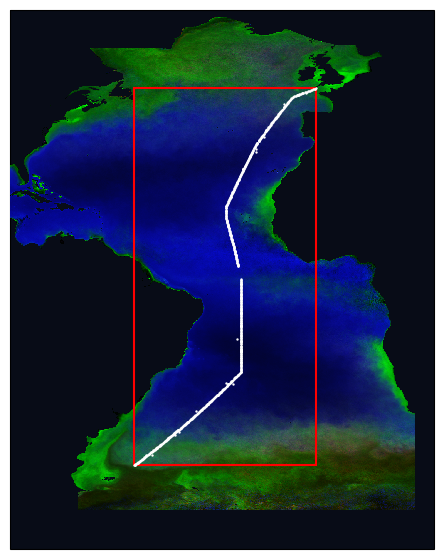

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [19]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(projection=ccrs.PlateCarree(), facecolor="#080c17")
ax2 = data_norm.plot.imshow(
    transform=ccrs.PlateCarree(), interpolation="none", zorder=3
)

# Add bounding box
ax1.add_patch(
    Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor="red",
        facecolor="none",
        linewidth=1.5,
        transform=ccrs.PlateCarree(),
        zorder=4,
    )
)

ax1.scatter(AMT_df.Lon, AMT_df.Lat, color='white', marker='o', s=0.5, transform=ccrs.PlateCarree(), label='AMT', zorder=5)

plt.show()

In [20]:
# fig.savefig("moana_snapshot_withAMTstns_boundingbox.png", format="png", dpi=600)

We then select the data within our area of interest (bounding box option).

In [21]:
tl = dataset_phy.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
tl

<xarray.Dataset> Size: 2GB
Dimensions:          (date: 376, lat: 978, lon: 472)
Coordinates:
  * lat              (lat) float32 4kB 49.55 49.45 49.35 ... -48.05 -48.15
  * lon              (lon) float32 2kB -52.65 -52.55 -52.45 ... -5.65 -5.55
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date, lat, lon) float32 694MB dask.array<chunksize=(1, 308, 472), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 694MB dask.array<chunksize=(1, 308, 472), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 694MB dask.array<chunksize=(1, 308, 472), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

In [98]:
tl_bgc = dataset_bgc.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
tl_bgc

<xarray.Dataset> Size: 2GB
Dimensions:       (date: 387, lat: 978, lon: 472)
Coordinates:
  * lat           (lat) float32 4kB 49.55 49.45 49.35 ... -47.95 -48.05 -48.15
  * lon           (lon) float32 2kB -52.65 -52.55 -52.45 ... -5.75 -5.65 -5.55
  * date          (date) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-0...
Data variables:
    carbon_phyto  (date, lat, lon) float32 715MB dask.array<chunksize=(1, 108, 472), meta=np.ndarray>
    poc           (date, lat, lon) float32 715MB dask.array<chunksize=(1, 108, 472), meta=np.ndarray>
    chlor_a       (date, lat, lon) float32 715MB dask.array<chunksize=(1, 108, 472), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.CARBON.V3_0....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CARBON/3.0
    data_bins:                         554626
    data_minimum:                      0.59064007
    data_maximum:                      1000.0002

### Plot the timelines with spatial averages and standard deviations

We want to run some statistics within our area. Here we are looking at the average and standard deviation for each group.

In [22]:
region_mean = tl.mean(dim=["lat", "lon"])
region_std = tl.std(dim=["lat", "lon"])

lon_mean = tl.mean(dim=["lon"])
lon_std = tl.std(dim=["lon"])

In [100]:
region_mean_bgc = tl_bgc.mean(dim=["lat", "lon"])
region_std_bgc = tl_bgc.std(dim=["lat", "lon"])

lon_mean_bgc = tl_bgc.mean(dim=["lon"])
lon_std_bgc = tl_bgc.std(dim=["lon"])

In [23]:
# region_mean.load()
# region_std.load()

# lon_mean.load()
# lon_std.load()

##why do we need to load?

<xarray.Dataset> Size: 4MB
Dimensions:          (date: 376, lat: 978)
Coordinates:
  * lat              (lat) float32 4kB 49.55 49.45 49.35 ... -48.05 -48.15
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date, lat) float32 1MB 9.936e+04 8.653e+04 ... 0.0 nan
    syncoccus_moana  (date, lat) float32 1MB 2.299e+04 3.098e+04 ... 0.0 nan
    picoeuk_moana    (date, lat) float32 1MB 9.061e+03 7.232e+03 ... 0.0 nan

In [101]:
region_mean
# region_mean_bgc

<xarray.Dataset> Size: 8kB
Dimensions:       (date: 387)
Coordinates:
  * date          (date) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-0...
Data variables:
    carbon_phyto  (date) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    poc           (date) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    chlor_a       (date) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>

In [102]:
lon_mean
# lon_mean_bgc

<xarray.Dataset> Size: 5MB
Dimensions:       (date: 387, lat: 978)
Coordinates:
  * lat           (lat) float32 4kB 49.55 49.45 49.35 ... -47.95 -48.05 -48.15
  * date          (date) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-0...
Data variables:
    carbon_phyto  (date, lat) float32 2MB dask.array<chunksize=(1, 108), meta=np.ndarray>
    poc           (date, lat) float32 2MB dask.array<chunksize=(1, 108), meta=np.ndarray>
    chlor_a       (date, lat) float32 2MB dask.array<chunksize=(1, 108), meta=np.ndarray>

In [26]:
lon_mean_df = lon_mean.to_dataframe()
lon_mean_df

prococcus_moana  syncoccus_moana  \
date                lat                                            
2024-04-01 11:01:27  49.549999    156828.218750     27284.451172   
                     49.450001    169521.765625     30568.955078   
                     49.349998    181585.781250     33737.402344   
                     49.250000    185648.203125     36565.214844   
                     49.150002    223645.843750     38168.703125   
...                                         ...              ...   
2025-05-01 10:28:24 -47.750000      1759.162354     29493.515625   
                    -47.850002     46410.804688     25947.503906   
                    -47.950001         0.000000      7970.620605   
                    -48.050003         0.000000     43129.574219   
                    -48.150002              NaN              NaN   

                                picoeuk_moana  
date                lat                        
2024-04-01 11:01:27  49.549999   11038.575195  
                     49.450001    8660.858398  
                     49.349998    9495.095703  
                     49.250000    8280.907227  
                     49.150002    7220.454590  
...                                       ...  
2025-05-01 10:28:24 -47.750000    5255.545898  
                    -47.850002    5088.725098  
                    -47.950001    8260.412109  
                    -48.050003    6875.636719  
                    -48.150002            NaN  

[367728 rows x 3 columns]

In [ ]:
lon_mean_bgc_df = lon_mean_bgc.to_dataframe()
lon_mean_bgc_df

In [27]:
monthly_means_fromlonmean = lon_mean.groupby("date.month").mean()
monthly_means_fromlonmean_df = monthly_means_fromlonmean.to_dataframe()
monthly_means_fromlonmean_df

prococcus_moana  syncoccus_moana  picoeuk_moana
month lat                                                        
1      49.549999    112216.554688     35536.519531    8936.080078
       49.450001    137023.703125     53510.871094    7443.566406
       49.349998    123604.679688     43222.773438    7595.661133
       49.250000    123755.781250     45508.535156    7398.338379
       49.150002    136476.437500     47798.558594    7928.300781
...                           ...              ...            ...
12    -47.750000    112167.109375     54819.535156   15472.912109
      -47.850002     96103.804688     51459.144531   15020.662109
      -47.950001     94150.156250     52211.351562   14953.131836
      -48.050003     87616.070312     49262.542969   14398.856445
      -48.150002     85895.203125     48772.699219   14447.400391

[11736 rows x 3 columns]

In [103]:
monthly_means_fromlonmean_bgc = lon_mean_bgc.groupby("date.month").mean()
monthly_means_fromlonmean_bgc_df = monthly_means_fromlonmean_bgc.to_dataframe()
monthly_means_fromlonmean_bgc_df

carbon_phyto         poc   chlor_a
month lat                                           
1      49.549999     23.398533   81.490273  0.339172
       49.450001     16.267305   75.468193  0.294500
       49.349998     15.501554   77.422920  0.309246
       49.250000     14.252073   76.584038  0.306650
       49.149998     14.528408   76.940704  0.301348
...                        ...         ...       ...
12    -47.750004     39.668633  107.015099  0.448592
      -47.850002     40.702076  108.959145  0.461313
      -47.950001     40.271458  108.224205  0.456640
      -48.050003     40.120232  108.634895  0.461288
      -48.150002     41.160862  109.249275  0.463987

[11736 rows x 3 columns]

We can now plot our timeline. We are going to plot the standard deviations as a shaded area around our mean with `fill_between`. We are using `seaborn` as `sns` to get their built-in plot styling options. It can be good to define some style elements, like `markersize`, ahead to avoid repeating them, but they can be changed for any individual dataset if needed. 

In this case, we also are drawing a second y axis with `twinx` for prochlorococcus, which has much higher concentrations than synechococcus and picoeukaryotes.

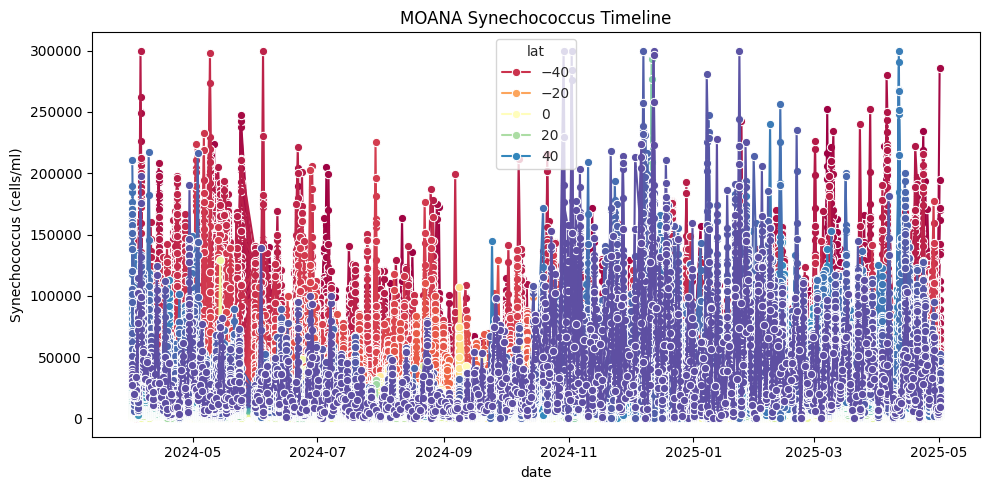

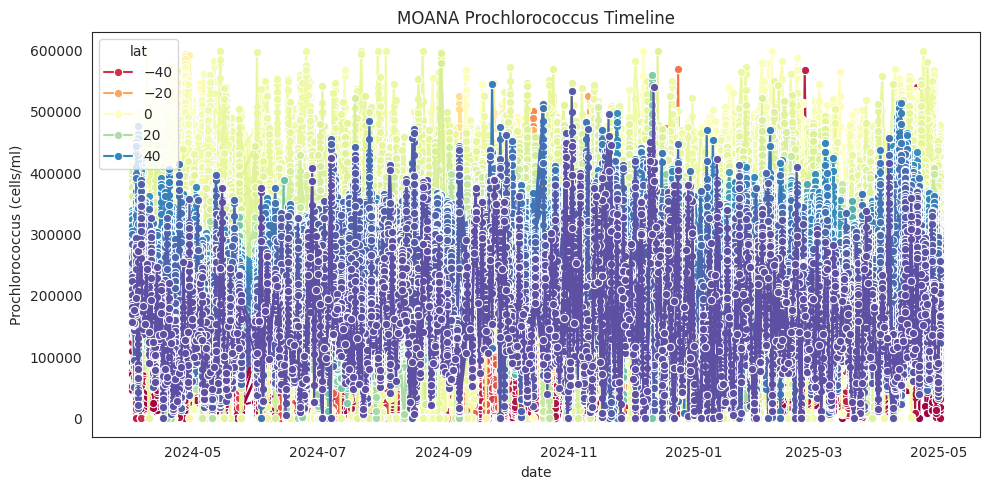

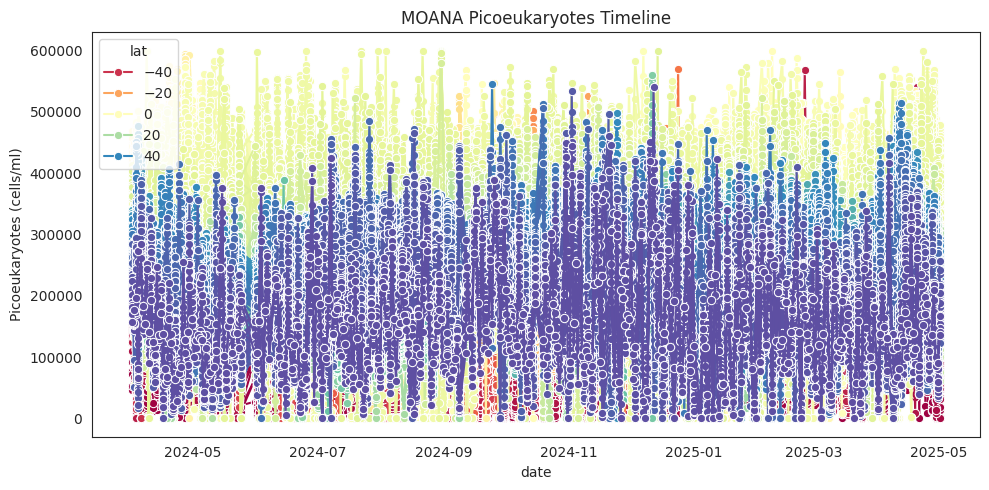

In [28]:
########## Synechococcus ##########

fig_syn_date, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("Spectral", as_cmap=True)

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=lon_mean_df, x="date", y='syncoccus_moana', hue='lat', marker='o', palette=palette)

ax1.set_ylabel("Synechococcus (cells/ml)")
plt.title("MOANA Synechococcus Timeline")
plt.tight_layout()
plt.show()

# ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")
# ax2.set_ylabel("Prochlorococcus (cells/ml)")
# ax1.set_xlabel("Date")

########## Prochlorococcus ##########

fig_pro_date, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("Spectral", as_cmap=True)

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=lon_mean_df, x="date", y='prococcus_moana', hue='lat', marker='o', palette=palette)

ax1.set_ylabel("Prochlorococcus (cells/ml)")
plt.title("MOANA Prochlorococcus Timeline")
plt.tight_layout()
plt.show()


########## Pico-eukaryotes ##########

fig_pico_date, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("Spectral", as_cmap=True)

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=lon_mean_df, x="date", y='prococcus_moana', hue='lat', marker='o', palette=palette)

ax1.set_ylabel("Picoeukaryotes (cells/ml)")
plt.title("MOANA Picoeukaryotes Timeline")
plt.tight_layout()
plt.show()


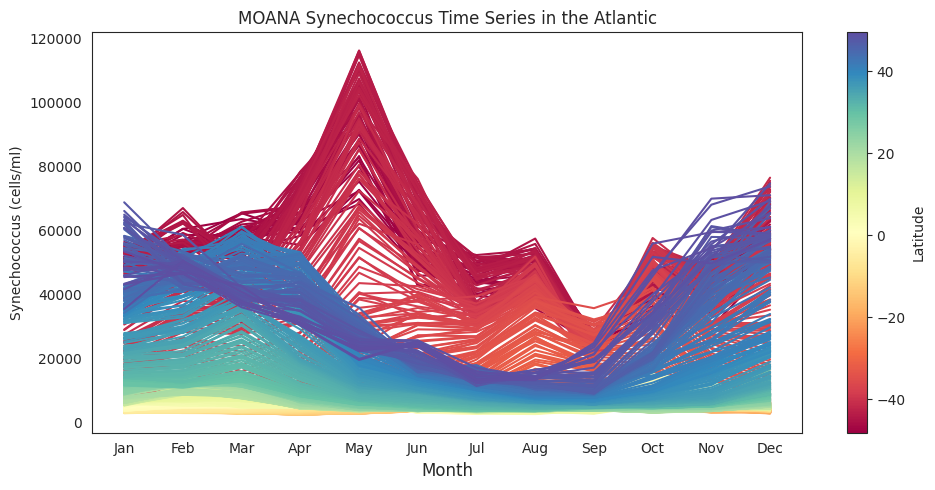

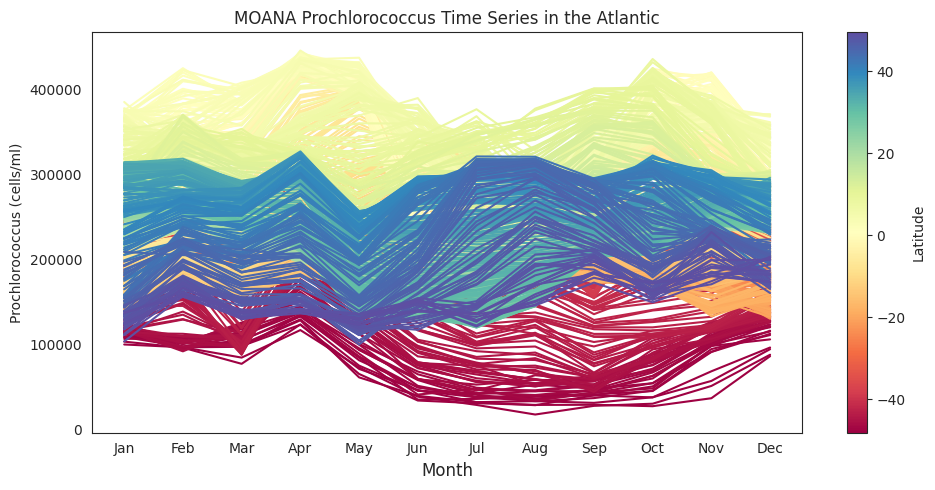

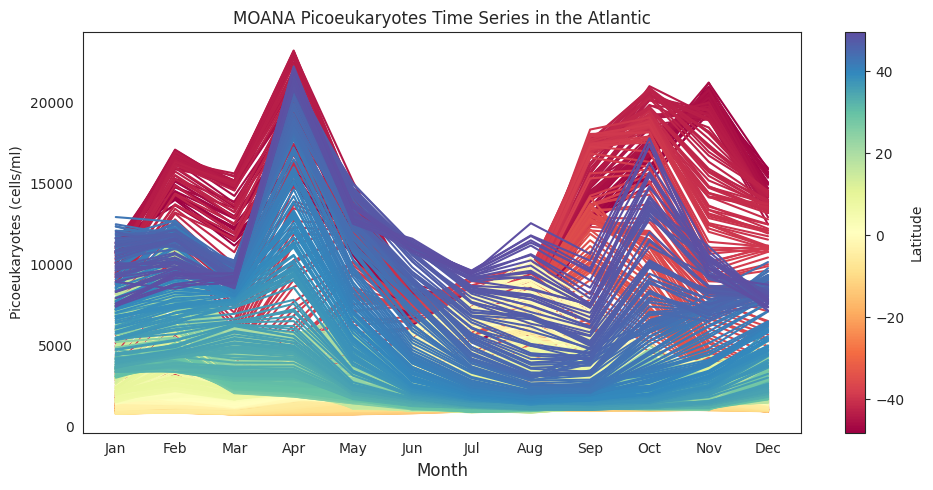

In [31]:
########## Synechococcus ##########

fig_syn_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
# palette = sns.color_palette("husl", 3)
palette=sns.color_palette("Spectral", as_cmap=True)

# months = monthly_means_fromlonmean["month"].values
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=monthly_means_fromlonmean_df, x="month", y='syncoccus_moana', hue='lat', palette=palette)
# cmap_div=sns.diverging_palette(145, 300, s=60, as_cmap=True)
norm = plt.Normalize(monthly_means_fromlonmean.lat.min(), monthly_means_fromlonmean.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Synechococcus (cells/ml)")
plt.title("MOANA Synechococcus Time Series in the Atlantic")
plt.tight_layout()
plt.show()

########## Prochlorococcus ##########

fig_pro_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
# palette = sns.color_palette("husl", 3)
palette=sns.color_palette("Spectral", as_cmap=True)

# months = monthly_means_fromlonmean["month"].values
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=monthly_means_fromlonmean_df, x="month", y='prococcus_moana', hue='lat', palette=palette) # removed marker
# cmap_div=sns.diverging_palette(145, 300, s=60, as_cmap=True)
norm = plt.Normalize(monthly_means_fromlonmean.lat.min(), monthly_means_fromlonmean.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Prochlorococcus (cells/ml)")
plt.title("MOANA Prochlorococcus Time Series in the Atlantic")
plt.tight_layout()
plt.show()

########## Picoeukaryotes ##########

fig_picoeuk_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
# palette = sns.color_palette("husl", 3)
palette=sns.color_palette("Spectral", as_cmap=True)

# months = monthly_means_fromlonmean["month"].values
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=monthly_means_fromlonmean_df, x="month", y='picoeuk_moana', hue='lat',palette=palette)
# cmap_div=sns.diverging_palette(145, 300, s=60, as_cmap=True)
norm = plt.Normalize(monthly_means_fromlonmean.lat.min(), monthly_means_fromlonmean.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Picoeukaryotes (cells/ml)")
plt.title("MOANA Picoeukaryotes Time Series in the Atlantic")
plt.tight_layout()
plt.show()

In [32]:
# fig_syn_month.savefig("moana_atlantic_syn_lat_time_series_monthlyavg.png", format="png", dpi=600)
# fig_pro_month.savefig("moana_atlantic_pro_lat_time_series_monthlyavg.png", format="png", dpi=600)
# fig_picoeuk_month.savefig("moana_atlantic_picoeuk_lat_time_series_monthlyavg.png", format="png", dpi=600)

In [38]:
# Round the latitudes then group by latitude and take mean
monthly_means_fromlonmean["lat"] = np.round(monthly_means_fromlonmean.lat)
monthly_means_eachlat = monthly_means_fromlonmean.groupby("lat").mean()
monthly_means_eachlat_df = monthly_means_eachlat.to_dataframe()
monthly_means_eachlat_df
# Now, you should have a monthly mean for each 1-degree of latitude. This should reduce the number of lines on the plots above.

In [104]:
# Do the same for BGC data:
monthly_means_fromlonmean_bgc["lat"] = np.round(monthly_means_fromlonmean_bgc.lat)
monthly_means_eachlat_bgc = monthly_means_fromlonmean_bgc.groupby("lat").mean()
monthly_means_eachlat_bgc_df = monthly_means_eachlat_bgc.to_dataframe()
monthly_means_eachlat_bgc_df

carbon_phyto         poc   chlor_a
lat   month                                    
-48.0 1         40.739750   85.034721  0.327248
      2         37.578300   89.986549  0.350695
      3         30.892324   88.384850  0.342760
      4         28.748791   77.687126  0.283707
      5         28.989008   81.792831  0.301777
...                   ...         ...       ...
 50.0 8         26.927160  112.651474  0.483105
      9         24.278820  106.044998  0.441898
      10        24.666626  126.406212  0.589679
      11        16.940626  109.562515  0.490593
      12        17.252775   90.359581  0.369256

[1188 rows x 3 columns]

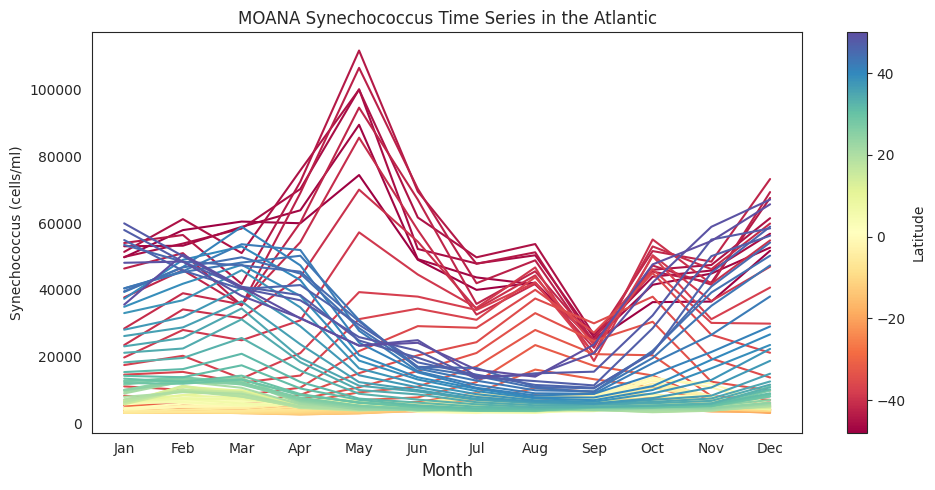

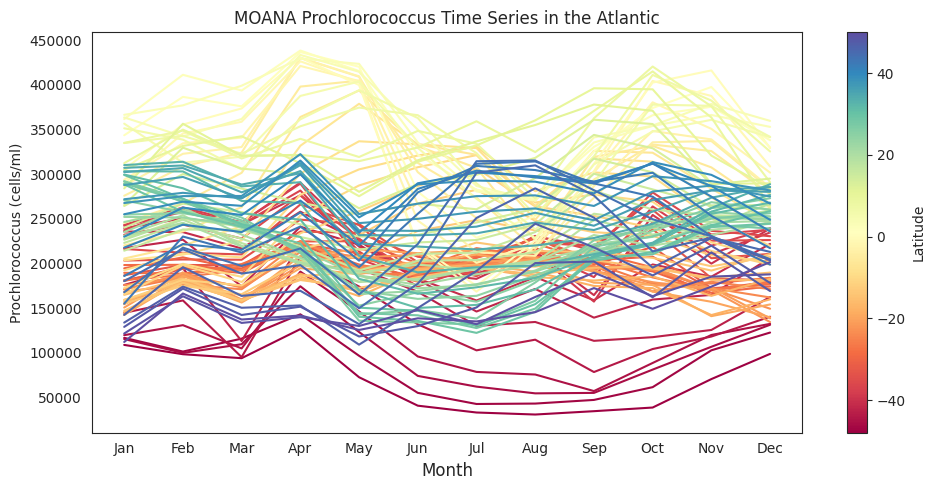

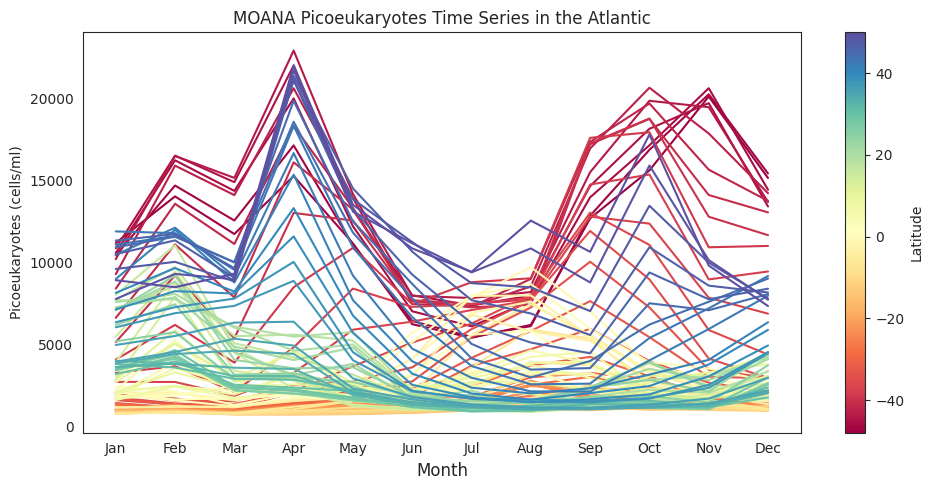

In [45]:
########## Synechococcus ##########

fig_syn_month_lat, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette=sns.color_palette("Spectral", as_cmap=True)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=monthly_means_eachlat_df, x="month", y='syncoccus_moana', hue='lat', palette=palette)
# cmap_div=sns.diverging_palette(145, 300, s=60, as_cmap=True)
norm = plt.Normalize(monthly_means_eachlat.lat.min(), monthly_means_eachlat.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Synechococcus (cells/ml)")
plt.title("MOANA Synechococcus Time Series in the Atlantic")
plt.tight_layout()
plt.show()

########## Prochlorococcus ##########

fig_pro_month_lat, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette=sns.color_palette("Spectral", as_cmap=True)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=monthly_means_eachlat_df, x="month", y='prococcus_moana', hue='lat', palette=palette) # removed marker
norm = plt.Normalize(monthly_means_eachlat.lat.min(), monthly_means_eachlat.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Prochlorococcus (cells/ml)")
plt.title("MOANA Prochlorococcus Time Series in the Atlantic")
plt.tight_layout()
plt.show()

########## Picoeukaryotes ##########

fig_picoeuk_month_lat, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette=sns.color_palette("Spectral", as_cmap=True)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged picoeuk data, colored by latitude
sns.lineplot(data=monthly_means_eachlat_df, x="month", y='picoeuk_moana', hue='lat',palette=palette)
norm = plt.Normalize(monthly_means_eachlat.lat.min(), monthly_means_eachlat.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Picoeukaryotes (cells/ml)")
plt.title("MOANA Picoeukaryotes Time Series in the Atlantic")
plt.tight_layout()
plt.show()

In [47]:
# fig_syn_month_lat.savefig("moana_atlantic_syn_lat1deg_time_series_monthlyavg.png", format="png", dpi=600)
# fig_pro_month_lat.savefig("moana_atlantic_pro_lat1deg_time_series_monthlyavg.png", format="png", dpi=600)
# fig_picoeuk_month_lat.savefig("moana_atlantic_picoeuk_lat1deg_time_series_monthlyavg.png", format="png", dpi=600)

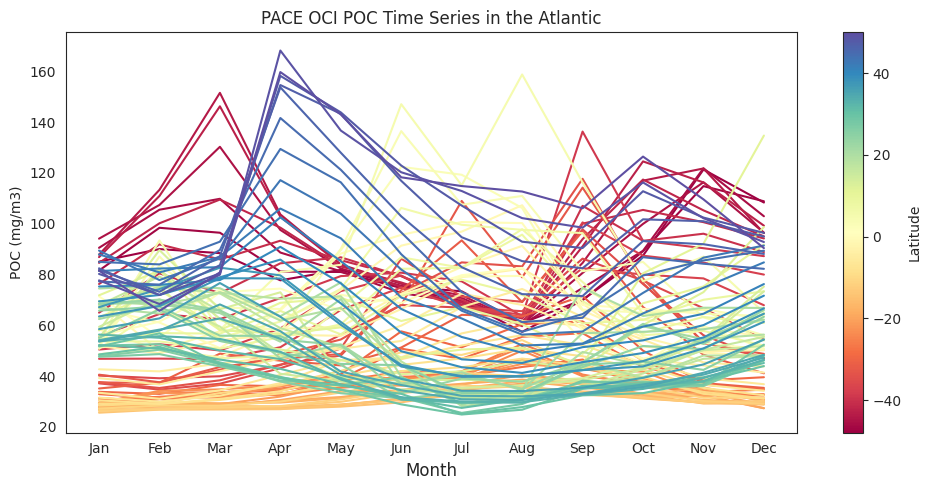

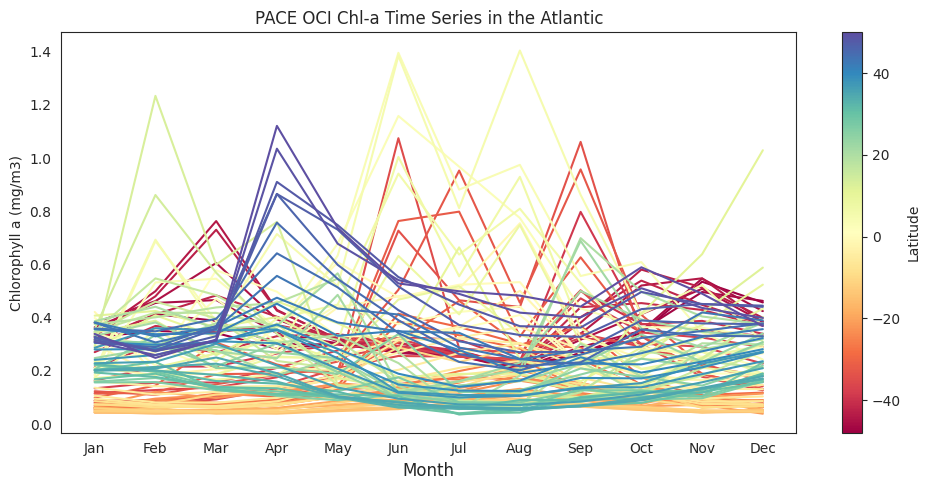

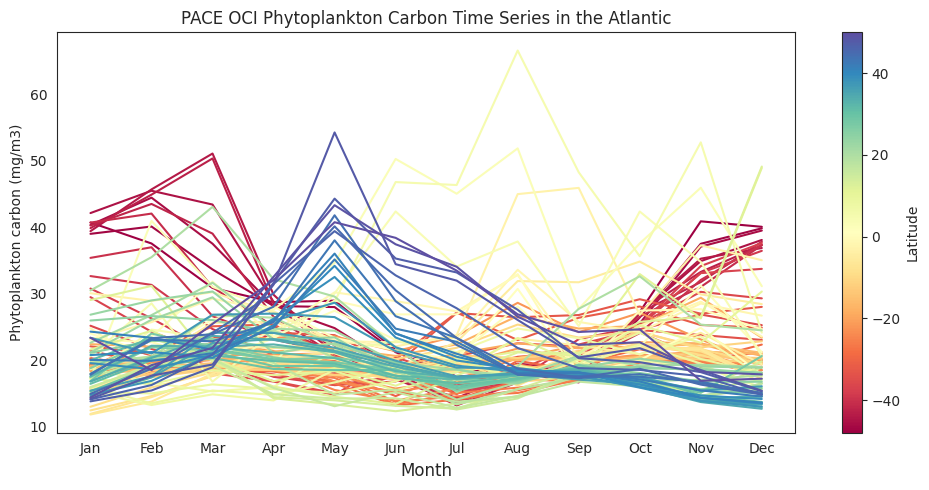

In [110]:
########## POC ##########
fig_poc_month_lat, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette=sns.color_palette("Spectral", as_cmap=True)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged picoeuk data, colored by latitude
sns.lineplot(data=monthly_means_eachlat_bgc_df, x="month", y='poc', hue='lat',palette=palette)
norm = plt.Normalize(monthly_means_eachlat_bgc.lat.min(), monthly_means_eachlat_bgc.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("POC (mg/m3)")
plt.title("PACE OCI POC Time Series in the Atlantic")
plt.tight_layout()
plt.show()

########## Chlorophyll ##########

fig_chl_month_lat, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette=sns.color_palette("Spectral", as_cmap=True)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged picoeuk data, colored by latitude
sns.lineplot(data=monthly_means_eachlat_bgc_df, x="month", y='chlor_a', hue='lat',palette=palette)
norm = plt.Normalize(monthly_means_eachlat_bgc.lat.min(), monthly_means_eachlat_bgc.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Chlorophyll a (mg/m3)")
plt.title("PACE OCI Chl-a Time Series in the Atlantic")
plt.tight_layout()
plt.show()

########## Phytoplankton Carbon ##########

fig_cphyto_month_lat, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette=sns.color_palette("Spectral", as_cmap=True)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

# Line plots of longitudinal averaged picoeuk data, colored by latitude
sns.lineplot(data=monthly_means_eachlat_bgc_df, x="month", y='carbon_phyto', hue='lat',palette=palette)
norm = plt.Normalize(monthly_means_eachlat_bgc.lat.min(), monthly_means_eachlat_bgc.lat.max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
ax1.get_legend().remove()
cbar=ax1.figure.colorbar(sm, ax=ax1)
cbar.set_label('Latitude')

ax1.set_xticks(range(1,13),labels=month_names)  # Set x-axis tick locations
ax1.set_xlabel("Month", fontsize=12)
# ax1.set_xticklabels(month_names)
ax1.set_ylabel("Phytoplankton carbon (mg/m3)")
plt.title("PACE OCI Phytoplankton Carbon Time Series in the Atlantic")
plt.tight_layout()
plt.show()



In [111]:
## SAVE FIGURES ##
# fig_poc_month_lat.savefig("pace_bgc_atlantic_poc_lat1deg_time_series_monthlyavg.png", format="png", dpi=600)
# fig_chl_month_lat.savefig("pace_bgc_atlantic_chl_lat1deg_time_series_monthlyavg.png", format="png", dpi=600)
# fig_cphyto_month_lat.savefig("pace_bgc_atlantic_cphyto_lat1deg_time_series_monthlyavg.png", format="png", dpi=600)


## Subregional analyses:
#### Tropical: -23.5° to 23.5°
#### Subtropical: 23.5° and 35° and -23.5° and -35°
#### Temperate: 35° to 50°
#### Subpolar: 50° to 70°
#### Polar: > 70°

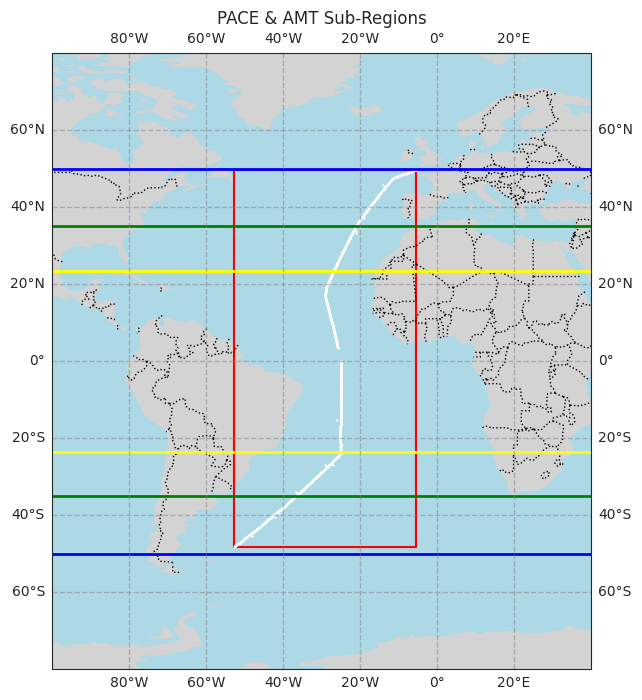

In [140]:
## Map plot of sub-regions
fig_map_subregions = plt.figure(figsize=(10, 8))
ax = fig_map_subregions.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-30)) # Center on Atlantic

# Add land and ocean features
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.OCEAN, color='lightblue')
# ax.add_feature(cfeature.COASTLINES)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the extent of the map to focus on the Atlantic
# Adjust these values to define the desired Atlantic region
ax.set_extent([-100, 40, -80, 80], crs=ccrs.PlateCarree())

# Add domain box
ax.add_patch(
    Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor="red",
        facecolor="none",
        linewidth=1.5,
        transform=ccrs.PlateCarree()
    )
)

# Add sub-region lines
ax.axhline(y=23.5, color='yellow', linestyle='-', linewidth=2, label='Tropic')
ax.axhline(y=-23.5, color='yellow', linestyle='-', linewidth=2, label='Tropic')
ax.axhline(y=35, color='green', linestyle='-', linewidth=2, label='Subtropic')
ax.axhline(y=-35, color='green', linestyle='-', linewidth=2, label='Subtropic')
ax.axhline(y=50, color='blue', linestyle='-', linewidth=2, label='Temperate')
ax.axhline(y=-50, color='blue', linestyle='-', linewidth=2, label='Temperate')


ax.scatter(AMT_df.Lon, AMT_df.Lat, color='white', marker='o', s=0.5, transform=ccrs.PlateCarree(), label='AMT')

# Add gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Add a title
plt.title("PACE & AMT Sub-Regions")

# Show the plot
plt.show()

# fig_map_subregions.savefig("pace_amt_subregions_latitudes_bbox.png", format="png", dpi=600)

In [51]:
# monthly_means_eachlat for MOANA PCC!
tropic = monthly_means_eachlat.sel(lat=slice(-23.5, 23.5))
subtropic_north = monthly_means_eachlat.sel(lat=slice(23.5, 35))
subtropic_south = monthly_means_eachlat.sel(lat=slice(-30,-23.5))
temperate_north = monthly_means_eachlat.sel(lat=slice(35, 50))
temperate_south = monthly_means_eachlat.sel(lat=slice(-50,-35))
subpolar_north = monthly_means_eachlat.sel(lat=slice(50, 70))
subpolar_south = monthly_means_eachlat.sel(lat=slice(-70,-50))

# subtropic = xr.concat([subtropic_south, subtropic_south], dim='lat') # Not sure if dim='lat' is correct.

In [55]:
# Take mean of all values within each subregion (keep "month" coordinate)
tropic_mean = tropic.mean(dim="lat")
subtropic_north_mean = subtropic_north.mean(dim="lat")
subtropic_south_mean = subtropic_south.mean(dim="lat")
temperate_north_mean = temperate_north.mean(dim="lat")
temperate_south_mean = temperate_south.mean(dim="lat")
subpolar_north_mean = subpolar_north.mean(dim="lat")
subpolar_south_mean = subpolar_south.mean(dim="lat") # may be filled with NaNs due to low coverage near South Polar region?

# calculate standard deviations and add to plots below!

In [113]:
# Run the same code but for the PACE BGC!
tropic_bgc = monthly_means_eachlat_bgc.sel(lat=slice(-23.5, 23.5))
subtropic_north_bgc = monthly_means_eachlat_bgc.sel(lat=slice(23.5, 35))
subtropic_south_bgc = monthly_means_eachlat_bgc.sel(lat=slice(-30,-23.5))
temperate_north_bgc = monthly_means_eachlat_bgc.sel(lat=slice(35, 50))
temperate_south_bgc = monthly_means_eachlat_bgc.sel(lat=slice(-50,-35))
subpolar_north_bgc = monthly_means_eachlat_bgc.sel(lat=slice(50, 70))
subpolar_south_bgc = monthly_means_eachlat_bgc.sel(lat=slice(-70,-50))

tropic_mean_bgc = tropic_bgc.mean(dim="lat")
subtropic_north_mean_bgc = subtropic_north_bgc.mean(dim="lat")
subtropic_south_mean_bgc = subtropic_south_bgc.mean(dim="lat")
temperate_north_mean_bgc = temperate_north_bgc.mean(dim="lat")
temperate_south_mean_bgc = temperate_south_bgc.mean(dim="lat")
subpolar_north_mean_bgc = subpolar_north_bgc.mean(dim="lat")
subpolar_south_mean_bgc = subpolar_south_bgc.mean(dim="lat") # may be filled with NaNs due to low coverage near South Polar region?


## Plots by region

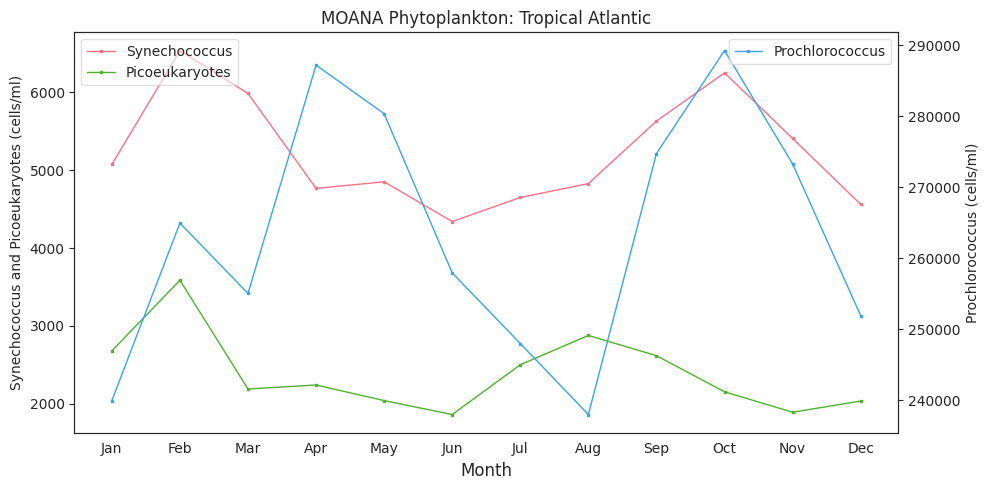

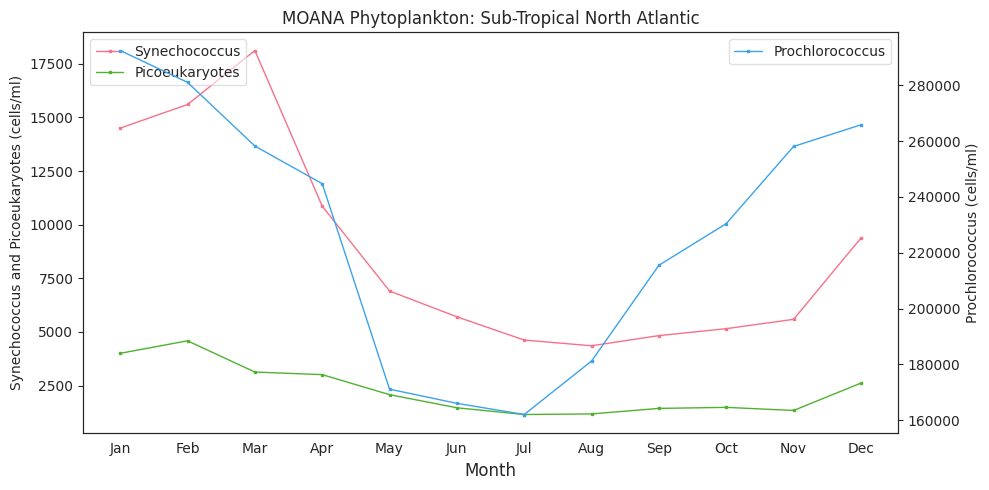

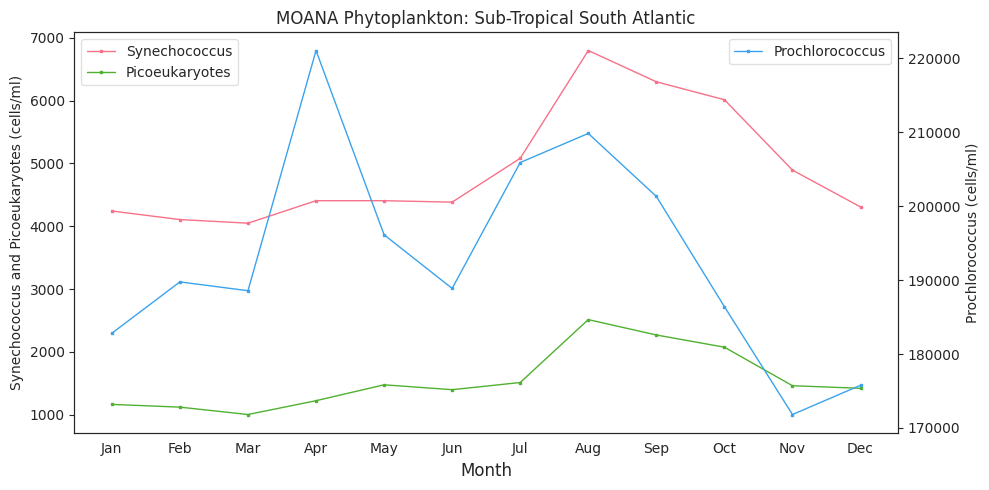

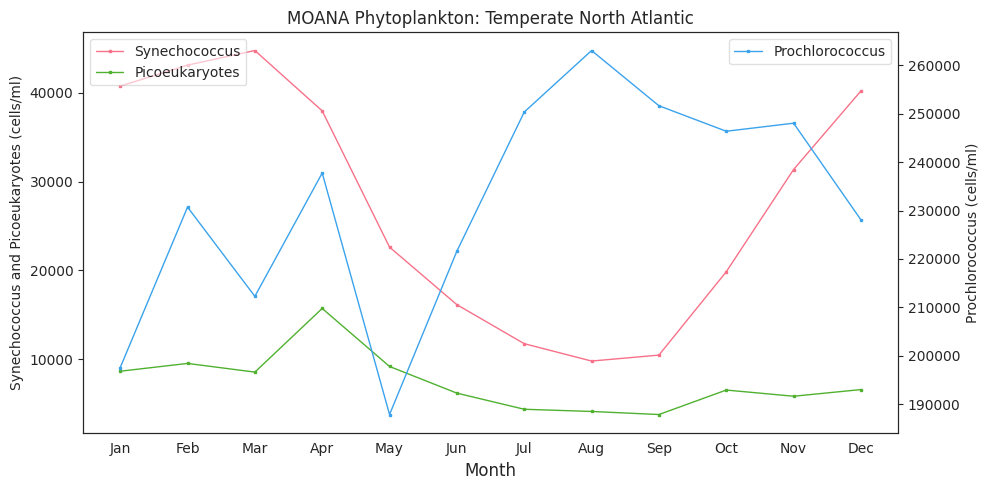

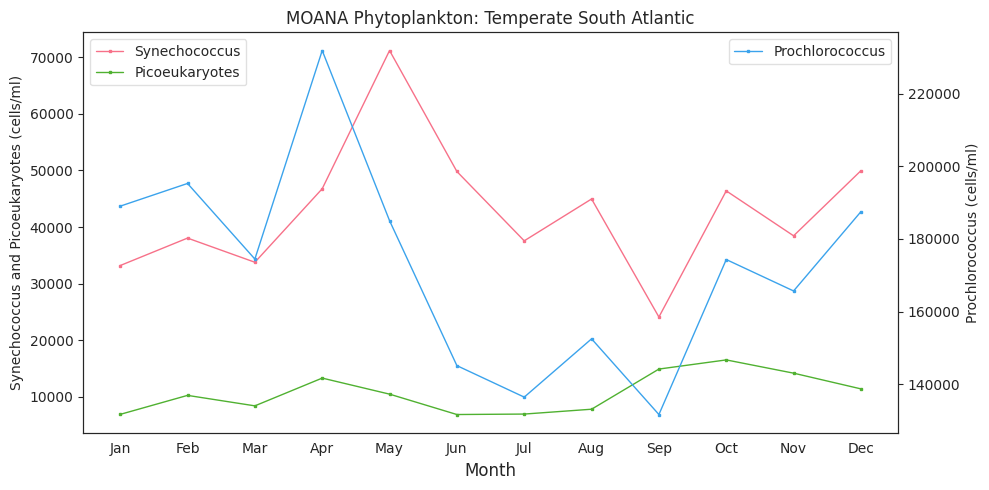

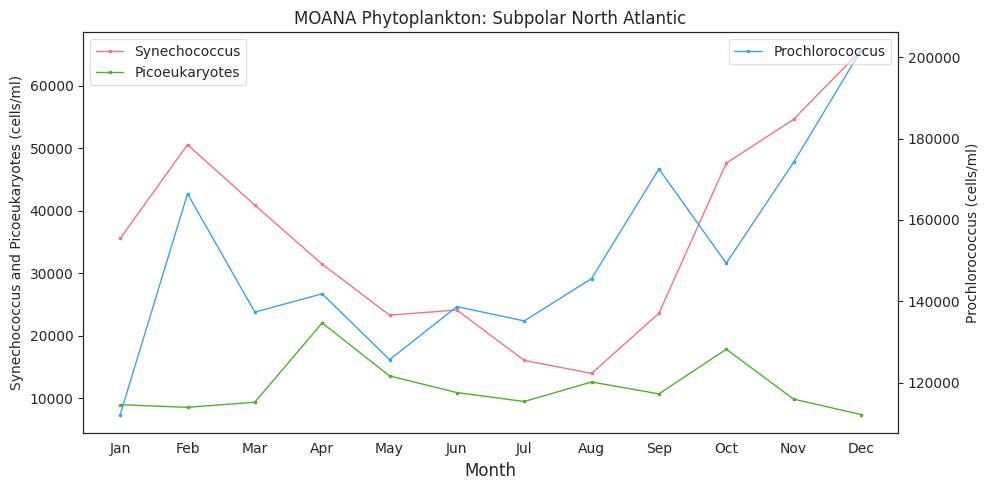

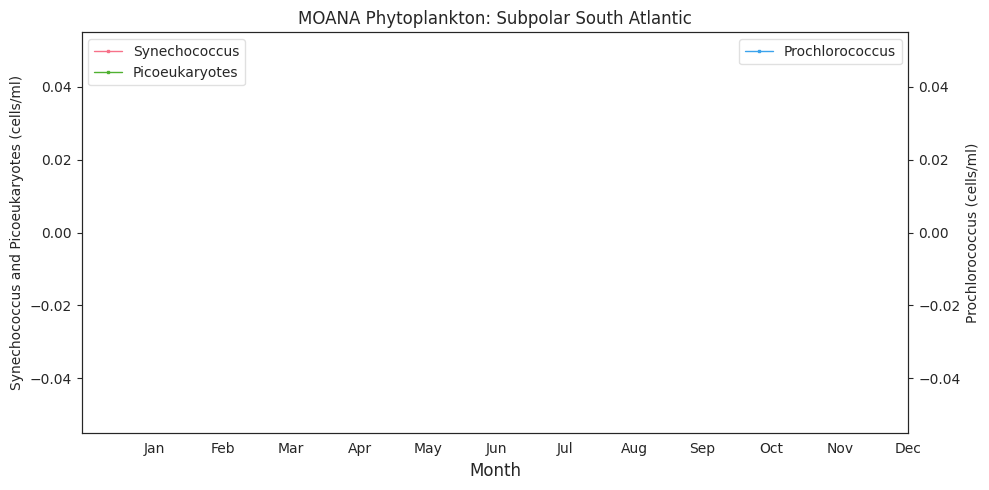

In [74]:
################### FOR MOANA PCC ######################

########## TROPICAL ##########

fig_tropical_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = tropic_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    tropic_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    tropic_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    tropic_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Tropical Atlantic")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_tropical_month.savefig("moana_tropical_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)


########## SUBTROPICAL: NORTH ##########

fig_subtropical_north_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = subtropic_north_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    subtropic_north_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    subtropic_north_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    subtropic_north_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Sub-Tropical North Atlantic")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_subtropical_north_month.savefig("moana_subtropical_north_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)

########## SUBTROPICAL: SOUTH ##########

fig_subtropical_south_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = subtropic_south_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    subtropic_south_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    subtropic_south_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    subtropic_south_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Sub-Tropical South Atlantic")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_subtropical_south_month.savefig("moana_subtropical_south_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)

########## TEMPERATE: NORTH ##########

fig_temperate_north_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = temperate_north_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    temperate_north_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    temperate_north_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    temperate_north_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Temperate North Atlantic")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_temperate_north_month.savefig("moana_temperate_north_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)

########## TEMPERATE: SOUTH ##########

fig_temperate_south_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = temperate_south_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    temperate_south_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    temperate_south_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    temperate_south_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Temperate South Atlantic")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_temperate_south_month.savefig("moana_temperate_south_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)

########## SUBPOLAR: NORTH ##########

fig_subpolar_north_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = subpolar_north_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    subpolar_north_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    subpolar_north_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    subpolar_north_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Subpolar North Atlantic")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_subpolar_north_month.savefig("moana_subpolar_north_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)

########## SUBPOLAR: SOUTH ##########

fig_subpolar_south_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = subpolar_south_mean["month"].values

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

ax1.plot(
    months,
    subpolar_south_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.plot(
    months,
    subpolar_south_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")

ax2 = ax1.twinx()
ax2.plot(
    months,
    subpolar_south_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)

ax2.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title("MOANA Phytoplankton: Subpolar South Atlantic")
plt.tight_layout()
plt.show()

# fig_subpolar_south_month.savefig("moana_subpolar_south_atlantic_allphyto_monthlyavg.png", format="png", dpi=600)


## Plots by phyto group

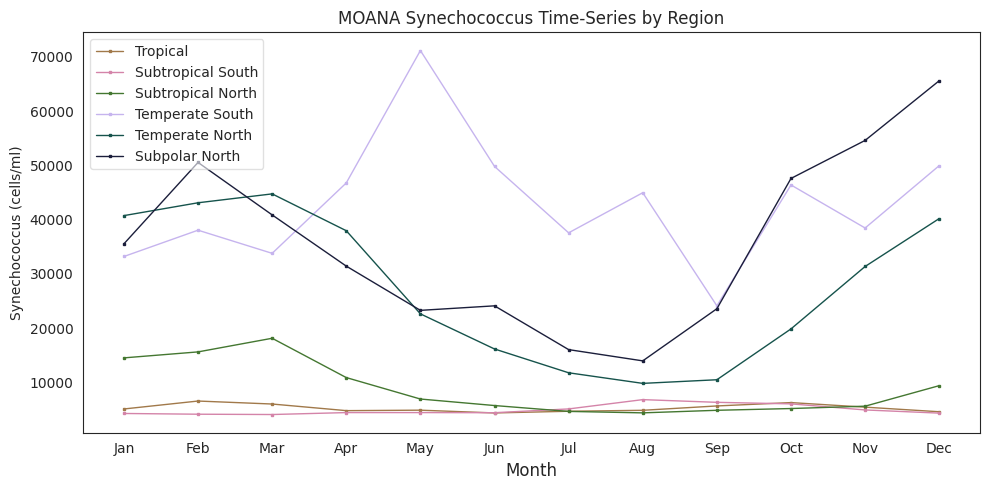

In [86]:
##### SYNECHOCOCCUS #####

fig_allRegions_syncoccus_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("cubehelix", 7)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

months = tropic_mean["month"].values

ax1.plot(
    months,
    tropic_mean["syncoccus_moana"].values,
    "s-",
    color=palette[3],
    label="Tropical",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_south_mean["month"].values

ax1.plot(
    months,
    subtropic_south_mean["syncoccus_moana"].values,
    "s-",
    color=palette[4],
    label="Subtropical South",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_north_mean["month"].values

ax1.plot(
    months,
    subtropic_north_mean["syncoccus_moana"].values,
    "s-",
    color=palette[2],
    label="Subtropical North",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_south_mean["month"].values

ax1.plot(
    months,
    temperate_south_mean["syncoccus_moana"].values,
    "s-",
    color=palette[5],
    label="Temperate South",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_north_mean["month"].values

ax1.plot(
    months,
    temperate_north_mean["syncoccus_moana"].values,
    "s-",
    color=palette[1],
    label="Temperate North",
    linewidth=linewidth,
    markersize=markersize,
)

months = subpolar_north_mean["month"].values

ax1.plot(
    months,
    subpolar_north_mean["syncoccus_moana"].values,
    "s-",
    color=palette[0],
    label="Subpolar North",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Synechococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title("MOANA Synechococcus Time-Series by Region")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_allRegions_syncoccus_month.savefig("moana_syncoccus_allregions_monthlyavg.png", format="png", dpi=600)


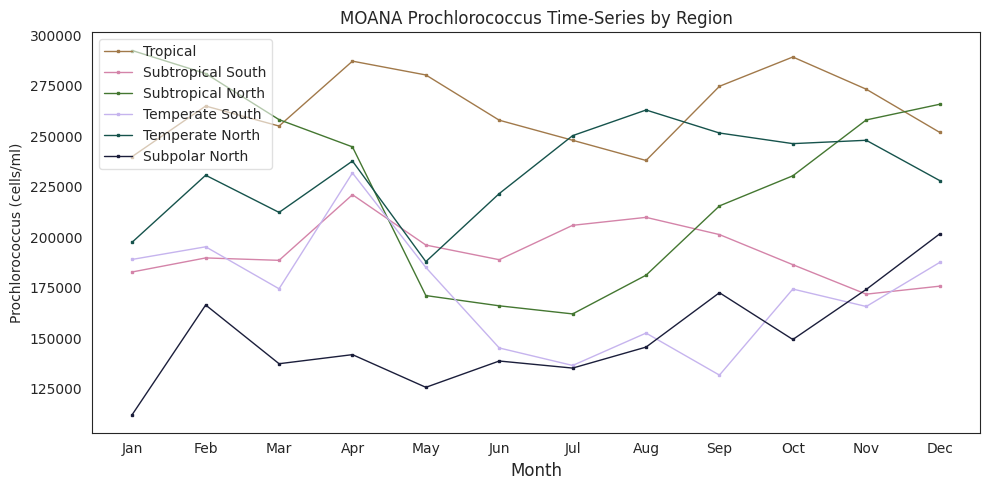

In [85]:
##### PROCHLOROCOCCUS #####
fig_allRegions_prococcus_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("cubehelix", 7)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

months = tropic_mean["month"].values

ax1.plot(
    months,
    tropic_mean["prococcus_moana"].values,
    "s-",
    color=palette[3],
    label="Tropical",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_south_mean["month"].values

ax1.plot(
    months,
    subtropic_south_mean["prococcus_moana"].values,
    "s-",
    color=palette[4],
    label="Subtropical South",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_north_mean["month"].values

ax1.plot(
    months,
    subtropic_north_mean["prococcus_moana"].values,
    "s-",
    color=palette[2],
    label="Subtropical North",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_south_mean["month"].values

ax1.plot(
    months,
    temperate_south_mean["prococcus_moana"].values,
    "s-",
    color=palette[5],
    label="Temperate South",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_north_mean["month"].values

ax1.plot(
    months,
    temperate_north_mean["prococcus_moana"].values,
    "s-",
    color=palette[1],
    label="Temperate North",
    linewidth=linewidth,
    markersize=markersize,
)

months = subpolar_north_mean["month"].values

ax1.plot(
    months,
    subpolar_north_mean["prococcus_moana"].values,
    "s-",
    color=palette[0],
    label="Subpolar North",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Prochlorococcus (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title("MOANA Prochlorococcus Time-Series by Region")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_allRegions_prococcus_month.savefig("moana_proccoccus_allregions_monthlyavg.png", format="png", dpi=600)


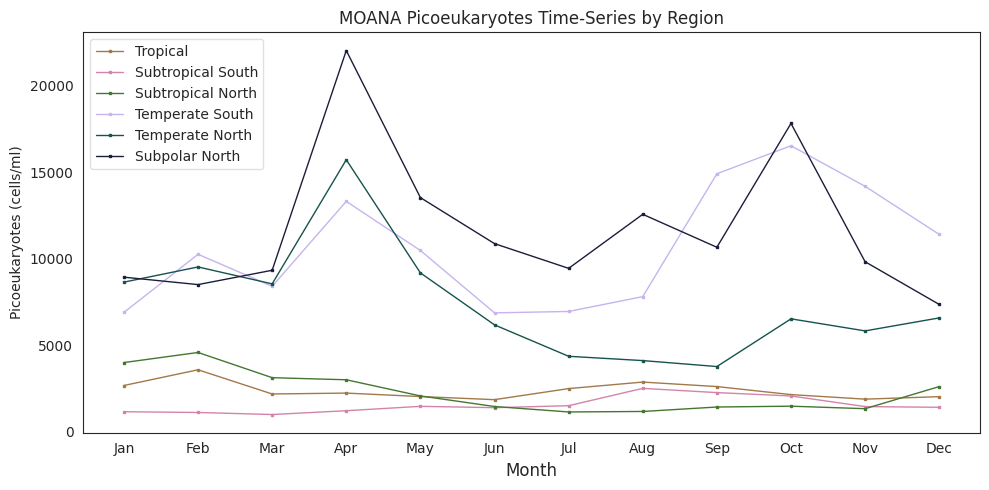

In [83]:
##### PICOEUKARYOTES #####
fig_allRegions_picoeuk_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("cubehelix", 7)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

months = tropic_mean["month"].values

ax1.plot(
    months,
    tropic_mean["picoeuk_moana"].values,
    "s-",
    color=palette[3],
    label="Tropical",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_south_mean["month"].values

ax1.plot(
    months,
    subtropic_south_mean["picoeuk_moana"].values,
    "s-",
    color=palette[4],
    label="Subtropical South",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_north_mean["month"].values

ax1.plot(
    months,
    subtropic_north_mean["picoeuk_moana"].values,
    "s-",
    color=palette[2],
    label="Subtropical North",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_south_mean["month"].values

ax1.plot(
    months,
    temperate_south_mean["picoeuk_moana"].values,
    "s-",
    color=palette[5],
    label="Temperate South",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_north_mean["month"].values

ax1.plot(
    months,
    temperate_north_mean["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Temperate North",
    linewidth=linewidth,
    markersize=markersize,
)

months = subpolar_north_mean["month"].values

ax1.plot(
    months,
    subpolar_north_mean["picoeuk_moana"].values,
    "s-",
    color=palette[0],
    label="Subpolar North",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Picoeukaryotes (cells/ml)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title("MOANA Picoeukaryotes Time-Series by Region")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_allRegions_picoeuk_month.savefig("moana_picoeuk_allregions_monthlyavg.png", format="png", dpi=600)


## Add in PACE BGC Data (POC, Cphyto, Chla)

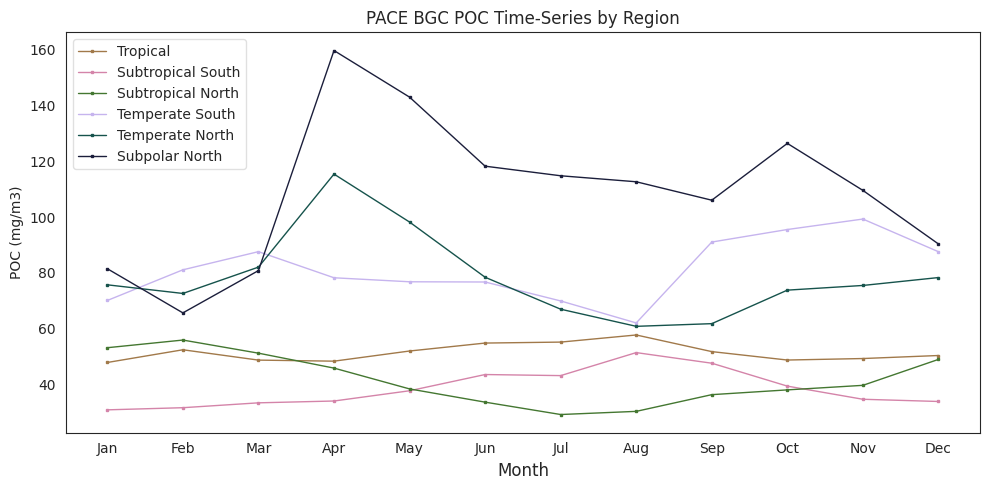

In [115]:
##### POC #####
fig_allRegions_POC_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("cubehelix", 7)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

months = tropic_mean_bgc["month"].values

ax1.plot(
    months,
    tropic_mean_bgc["poc"].values,
    "s-",
    color=palette[3],
    label="Tropical",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_south_mean_bgc["month"].values

ax1.plot(
    months,
    subtropic_south_mean_bgc["poc"].values,
    "s-",
    color=palette[4],
    label="Subtropical South",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_north_mean_bgc["month"].values

ax1.plot(
    months,
    subtropic_north_mean_bgc["poc"].values,
    "s-",
    color=palette[2],
    label="Subtropical North",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_south_mean_bgc["month"].values

ax1.plot(
    months,
    temperate_south_mean_bgc["poc"].values,
    "s-",
    color=palette[5],
    label="Temperate South",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_north_mean_bgc["month"].values

ax1.plot(
    months,
    temperate_north_mean_bgc["poc"].values,
    "s-",
    color=palette[1],
    label="Temperate North",
    linewidth=linewidth,
    markersize=markersize,
)

months = subpolar_north_mean_bgc["month"].values

ax1.plot(
    months,
    subpolar_north_mean_bgc["poc"].values,
    "s-",
    color=palette[0],
    label="Subpolar North",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("POC (mg/m3)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title("PACE BGC POC Time-Series by Region")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_allRegions_POC_month.savefig("pace_bgc_poc_allregions_monthlyavg.png", format="png", dpi=600)


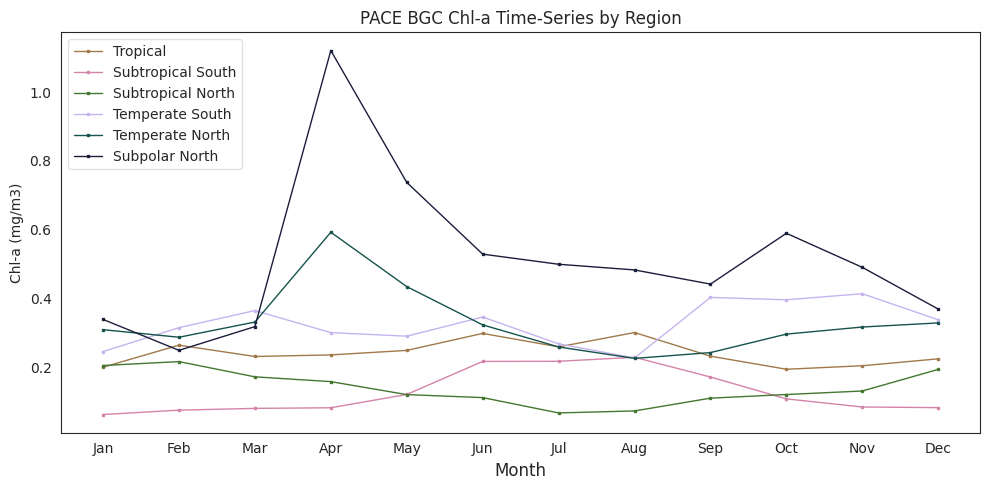

In [116]:
##### Chl-a #####
fig_allRegions_Chl_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("cubehelix", 7)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

months = tropic_mean_bgc["month"].values

ax1.plot(
    months,
    tropic_mean_bgc["chlor_a"].values,
    "s-",
    color=palette[3],
    label="Tropical",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_south_mean_bgc["month"].values

ax1.plot(
    months,
    subtropic_south_mean_bgc["chlor_a"].values,
    "s-",
    color=palette[4],
    label="Subtropical South",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_north_mean_bgc["month"].values

ax1.plot(
    months,
    subtropic_north_mean_bgc["chlor_a"].values,
    "s-",
    color=palette[2],
    label="Subtropical North",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_south_mean_bgc["month"].values

ax1.plot(
    months,
    temperate_south_mean_bgc["chlor_a"].values,
    "s-",
    color=palette[5],
    label="Temperate South",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_north_mean_bgc["month"].values

ax1.plot(
    months,
    temperate_north_mean_bgc["chlor_a"].values,
    "s-",
    color=palette[1],
    label="Temperate North",
    linewidth=linewidth,
    markersize=markersize,
)

months = subpolar_north_mean_bgc["month"].values

ax1.plot(
    months,
    subpolar_north_mean_bgc["chlor_a"].values,
    "s-",
    color=palette[0],
    label="Subpolar North",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Chl-a (mg/m3)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title("PACE BGC Chl-a Time-Series by Region")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_allRegions_Chl_month.savefig("pace_bgc_chl_allregions_monthlyavg.png", format="png", dpi=600)


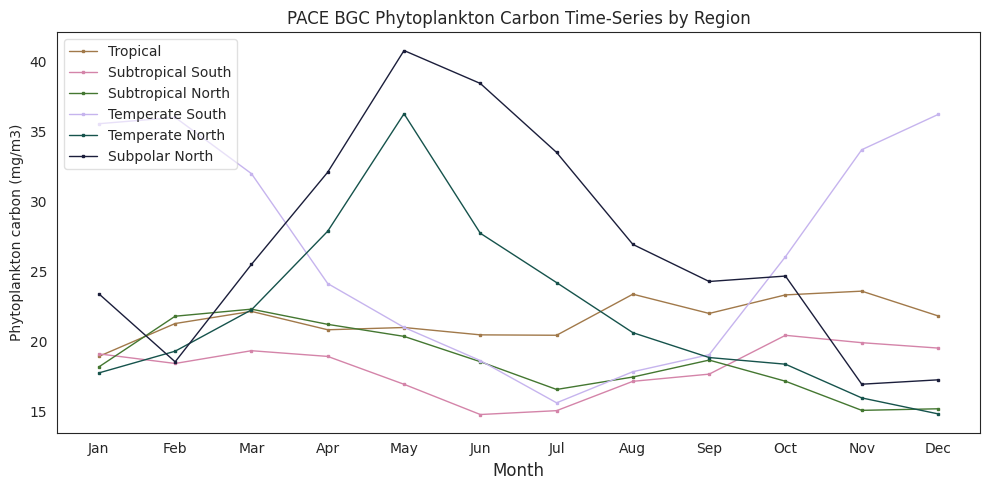

In [117]:
##### Cphyto #####
fig_allRegions_cphyto_month, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("cubehelix", 7)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]  # 

months = tropic_mean_bgc["month"].values

ax1.plot(
    months,
    tropic_mean_bgc["carbon_phyto"].values,
    "s-",
    color=palette[3],
    label="Tropical",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_south_mean_bgc["month"].values

ax1.plot(
    months,
    subtropic_south_mean_bgc["carbon_phyto"].values,
    "s-",
    color=palette[4],
    label="Subtropical South",
    linewidth=linewidth,
    markersize=markersize,
)

months = subtropic_north_mean_bgc["month"].values

ax1.plot(
    months,
    subtropic_north_mean_bgc["carbon_phyto"].values,
    "s-",
    color=palette[2],
    label="Subtropical North",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_south_mean_bgc["month"].values

ax1.plot(
    months,
    temperate_south_mean_bgc["carbon_phyto"].values,
    "s-",
    color=palette[5],
    label="Temperate South",
    linewidth=linewidth,
    markersize=markersize,
)

months = temperate_north_mean_bgc["month"].values

ax1.plot(
    months,
    temperate_north_mean_bgc["carbon_phyto"].values,
    "s-",
    color=palette[1],
    label="Temperate North",
    linewidth=linewidth,
    markersize=markersize,
)

months = subpolar_north_mean_bgc["month"].values

ax1.plot(
    months,
    subpolar_north_mean_bgc["carbon_phyto"].values,
    "s-",
    color=palette[0],
    label="Subpolar North",
    linewidth=linewidth,
    markersize=markersize,
)

ax1.set_xlabel("Month", fontsize=12)
ax1.set_xticks(range(1, 13),labels=month_names)
ax1.set_ylabel("Phytoplankton carbon (mg/m3)")

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title("PACE BGC Phytoplankton Carbon Time-Series by Region")
plt.tight_layout()
plt.show()

# SAVE FIGURE
fig_allRegions_cphyto_month.savefig("pace_bgc_cphyto_allregions_monthlyavg.png", format="png", dpi=600)


# Attempt at Hovmoller Diagram
## Still figuring this out!!!!


In [46]:
# Load in data tables from Olivia's processing
pro_df = pd.read_csv('prococcus_monthly_stats_normalized.csv')
pro_df

month_year     Lat     Lon        cv      mean    median       std  \
0      Apr 2024 -48.199 -52.692  0.203220  0.212030  0.161927  0.413294   
1      Apr 2024 -48.115 -52.572  0.153168  0.267295  0.307108  0.392693   
2      Apr 2024 -48.014 -52.436  0.098673  0.381019  0.481549  0.360611   
3      Apr 2024 -47.933 -52.353  0.085281  0.393336  0.357893  0.321743   
4      Apr 2024 -47.860 -52.236  0.089379  0.422539  0.464721  0.362241   
...         ...     ...     ...       ...       ...       ...       ...   
8933   Sep 2024  11.790 -27.795  0.015499  0.755445  0.753504  0.112303   
8934   Sep 2024  11.976 -27.841  0.017235  0.775067  0.775067  0.128129   
8935   Sep 2024  12.355 -27.937  0.018653  0.721446  0.706888  0.129077   
8936   Sep 2024   6.256 -26.381  0.000000  0.530973  0.530973  0.000000   
8937   Sep 2024   7.875 -26.729  0.000000  0.595668  0.595668  0.000000   

          value  
0     prococcus  
1     prococcus  
2     prococcus  
3     prococcus  
4     prococcus  
...         ...  
8933  prococcus  
8934  prococcus  
8935  prococcus  
8936  prococcus  
8937  prococcus  

[8938 rows x 8 columns]

In [48]:
# from datetime import datetime

# month_year_data= pro_df.month_year
# date_object = datetime.strptime(month_year_data, "%b %Y")
# numerical_date_string = date_object.strftime("%Y-%m-%d")
# print(numerical_date_string)

# min(pro_df.Lat), max(pro_df.Lat), min(pro_df.Lon), max(pro_df.Lon)

# # Define custom bin edges
# lat_bins = np.arange(-50, 50, 1)
# # date_bin_edges

# counts, bin_edges = np.histogram(data, bins=lat_bins)
# print("Bin Counts:", counts)
# print("Bin Edges:", bin_edges)


# # counts, date_bin_edges, lat_bin_edges = np.histogram2d(pro_df.datenum, pro_df.Lat), bins=[date_bin_edges, lat_bin_edges])

# # Use numpy's histogram function
# hist_counts, bins_returned = np.histogram(pro_df, bins=lat_bin_edges)
# print("Histogram counts:", hist_counts)
# print("Bin edges:", bins_returned)

(-48.199, 49.638, -52.692, -5.502)

In [63]:
# lat_bins = np.arange(-50, 52, 1)
# counts, bin_edges = np.histogram(pro_df.Lat, bins=lat_bins)
# bin_indices = np.digitize(pro_df.Lat, bins=lat_bins)
# print("Bin Counts:", counts)
# print("Bin Edges:", bin_edges)
# print("Bin Indices:", bin_indices)

# pro_df['lat_bin_idx']=bin_indices
# pro_df

# pro_df_grouped = pro_df.groupby('lat_bin_idx')
# pro_df_grouped

# pro_df_lat_average = pro_df_grouped['mean'].mean() # 'mean' column is the prochlorococcus data we want to average over latitudes

# pro_df_lat_average

# # Calculate the sum of values in each bin
# sum_per_bin = np.bincount(bin_indices, weights=pro_df.mean)

# # Calculate the count of points in each bin
# count_per_bin = np.bincount(bin_indices)

# # Calculate the average (handle division by zero for empty bins)
# average_per_bin = np.divide(sum_per_bin, count_per_bin, out=np.full_like(sum_per_bin, np.nan, dtype=float), where=count_per_bin != 0)

# print("Average points per bin:", average_per_bin)

Bin Counts: [  0  37 143 125 137 117 143 118 128 128 182 130 114 117  90 125 142 117
 146 118 108 107 138 124 108  92  91  78  65  91  79 209  98  81  80  82
  83  98  84  84  84  84  96  80  63  80  94  68  95  81  13   0   0  50
  68  57  45  43  47  48  55  76  52  64  52  73  54  61  70  86  73  70
  72  76  78  89  91  78  91  92  78  78  95  95  79  91 104 103  76 104
  91  77 117  91  89  89  88 127 167 113   0]
Bin Edges: [-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51]
Bin Indices: [ 2  2  2 ... 63 57 58]


lat_bin_idx
2      0.199124
3      0.235005
4      0.275253
5      0.298970
6      0.292708
         ...   
96     0.317528
97     0.323962
98     0.307362
99     0.276158
100    0.203423
Name: mean, Length: 97, dtype: float64

In [58]:
# from datetime import datetime

# month_year_data= pro_df.month_year
# date_object = datetime.strptime(month_year_data, "%b %Y")
# numerical_date_string = date_object.strftime("%Y-%m-%d")
# print(numerical_date_string)

[back to top](#Contents)

<div class="alert alert-info" role="alert">
    
You have completed the notebook on PACE data visualization!

</div>